In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from lib.utils import non_max_suppression, intersection_over_union, load_checkpoint, cells_to_bboxes
from lib.utils import intersection_over_union as iou
from lib.YOLOV3 import YOLOv3 as YOLO
from albumentations.pytorch import ToTensorV2
import albumentations as A
from lib import config as C
import cv2
from torch.utils.data import DataLoader
from PIL import Image, ImageFile, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from lib.utils import (
    cells_to_bboxes,
    iou_width_height as iou,
    non_max_suppression as nms,
    plot_image
)

C:\Users\dokee\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#scale = 1.1
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=C.IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=int(C.IMAGE_SIZE),
            min_width=int(C.IMAGE_SIZE),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255, ),
        ToTensorV2(),
    ],
)


In [4]:
image_path = "lib/datasets/test_images/dead_end.png"
S=[C.IMAGE_SIZE // 32, C.IMAGE_SIZE // 16, C.IMAGE_SIZE // 8]
anchors = C.ANCHORS
image = np.array(Image.open(image_path).convert("RGB"))
augmentations = test_transforms(image=image)
image1 = augmentations["image"]
image1.size(), image.shape

(torch.Size([3, 416, 416]), (1080, 1920, 3))

In [24]:
test = image1.to("cpu").numpy()
test

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [29]:
test.shape

(3, 416, 416)

In [30]:
for i in range(3):
    for j in range(416):
        print(j, max(test[i][j]))

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.5568628
85 0.79215693
86 0.78823537
87 0.7803922
88 0.7686275
89 0.7803922
90 0.7725491
91 0.7725491
92 0.76470596
93 0.7568628
94 0.74509805
95 0.73333335
96 0.7176471
97 0.7058824
98 0.69411767
99 0.6901961
100 0.6862745
101 0.68235296
102 0.6862745
103 0.6862745
104 0.69411767
105 0.69411767
106 0.6862745
107 0.6862745
108 0.6901961
109 0.69803923
110 0.72156864
111 0.74509805
112 0.7568628
113 0.76470596
114 0

In [ ]:
# zeros: 0-83 331-415
# ones: 84-330


In [5]:
def get_eval_boxes(x, model, anchors, iou_threshold, threshold, device="cuda"):
    model.eval()
    x = x.to(device)
    tmp = torch.reshape(x,(1,x.size()[0],x.size()[1],x.size()[2]))
    all_pred_boxes = []
    train_idx = 0
    with torch.no_grad():
        preditcions = model(tmp)
    batch_size = tmp.shape[0]
    bboxes = bboxes = [[] for _ in range(batch_size)]
    for i in range(3):
        S = preditcions[i].shape[2]
        anchor = torch.tensor([*anchors[i]]).to(device) * S
        boxes_scale_i = cells_to_bboxes(
            preditcions[i], anchor, S = S, is_preds=True
        
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box
    
    for idx in range(batch_size):
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold = iou_threshold,
            threshold = threshold,
            box_format = "midpoint"
        )
        
        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)
            train_idx += 1
    model.train()
    return all_pred_boxes

In [22]:
image_path = "lib/datasets/test_images/test2.png"
S=[C.IMAGE_SIZE // 32, C.IMAGE_SIZE // 16, C.IMAGE_SIZE // 8]
anchors = C.ANCHORS
image = np.array(Image.open(image_path).convert("RGB"))
#image = np.array(image.resize((C.IMAGE_SIZE, C.IMAGE_SIZE)))
# scaled_anchors = (
#     torch.tensor(C.ANCHORS)
#     * torch.tensor(C.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
# ).to(C.DEVICE)
augmentations = test_transforms(image=image)
image = augmentations["image"]
model = YOLO(num_classes=C.NUM_CLASSES).to(C.DEVICE)
check = "lib/models/checkpoint_test.pth.tar"
optimizer = optim.Adam(
        model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY
    )
load_checkpoint(
        check, model, optimizer, C.LEARNING_RATE
    )
anchors = C.ANCHORS

=> Loading checkpoint


In [36]:
image.size()

torch.Size([3, 416, 416])

In [23]:
pred_boxes = get_eval_boxes(image, model, C.ANCHORS, iou_threshold = C.NMS_IOU_THRESH, threshold=C.CONF_THRESHOLD)
pred_boxes

[[0,
  43.0,
  0.9150345921516418,
  0.7848599553108215,
  0.3690078556537628,
  0.07177267223596573,
  0.07404074817895889],
 [1,
  21.0,
  0.8734883069992065,
  0.788299024105072,
  0.37205764651298523,
  0.06388529390096664,
  0.06772920489311218],
 [2,
  9.0,
  0.8152072429656982,
  0.7834892272949219,
  0.3733171820640564,
  0.07105019688606262,
  0.06810178607702255]]

198.52848410606384
201.82225823402405
203.1825566291809


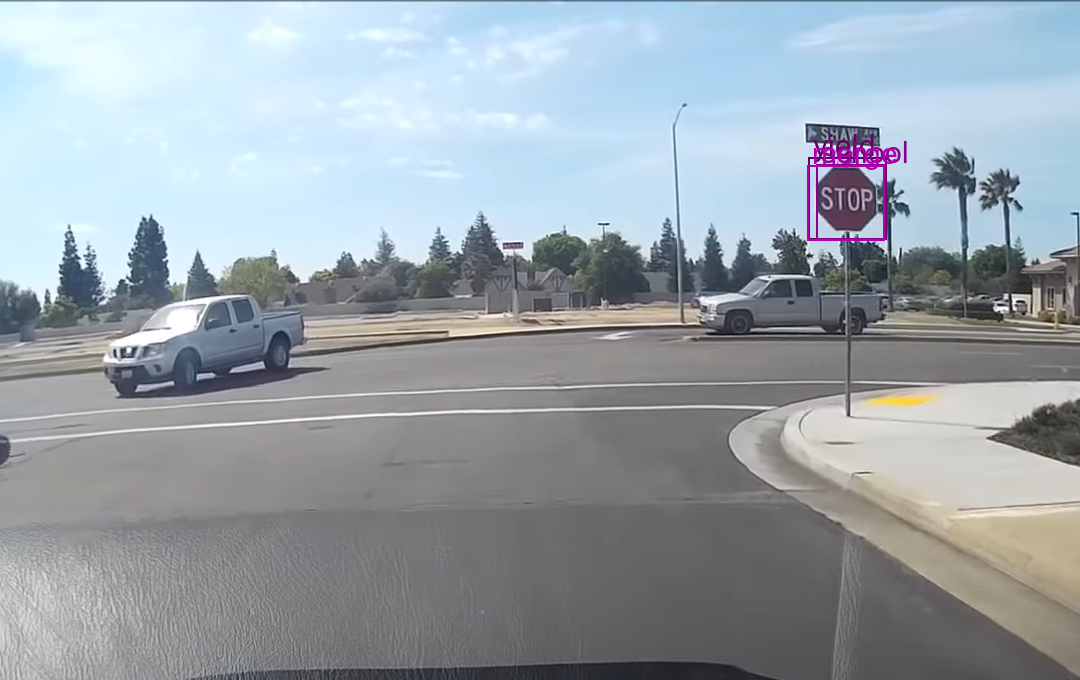

In [24]:
image = Image.open(image_path)
#image = image.resize((416, 416))
bboxes = pred_boxes
width, height = image.size
width, height
ids = pd.read_csv("lib/datasets/ids.csv")
ratio_height = height * C.IMAGE_SIZE / width
convert_height = (416 - ratio_height) / 2
for count, box in enumerate(bboxes):
    color = (100+count*int(155/4), 0, 100+count*int(155/4))
    name = ids[ids["ID"] == int(box[1])]["Name"].tolist()[0]
    x = box[3] * C.IMAGE_SIZE
    y = box[4] * C.IMAGE_SIZE
    y -= convert_height
    x, y = x / 416 * width,  y / ratio_height * height
    w = box[5] * width
    h = box[6] * width
    left, right, top, bottom = [(x - w / 2), (x + w / 2),
                                (y - h / 2), (y + h / 2)]
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    draw = ImageDraw.Draw(image)
    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=2, fill=color)
    font = ImageFont.truetype("arial.ttf", 30)
    draw.text((int(left+5),int(top-30)), name, fill=color, font=font)
image

In [168]:
np.

(852, 480)

In [158]:
image = image.to("cuda")
model.eval()
with torch.no_grad():
    tmp = torch.reshape(image,(1,image.size()[0],image.size()[1],image.size()[2]))
tests= model(tmp)
tests[0]

tensor([[[[[-8.5520e+00,  2.7708e-01,  1.1060e+00,  ..., -1.5225e+00,
            -2.8333e+00, -4.0969e+00],
           [-9.6735e+00, -1.2928e-01,  3.0914e-01,  ..., -1.7577e+00,
            -2.8847e+00, -4.0311e+00],
           [-9.3820e+00,  1.2461e+00,  5.1687e-01,  ..., -2.2679e+00,
            -3.1885e+00, -4.2420e+00],
           ...,
           [-1.3889e+01, -5.1784e-01,  5.9404e-01,  ..., -4.3356e+00,
            -2.6567e+00, -3.5129e+00],
           [-1.3073e+01, -1.3289e-01,  5.4707e-01,  ..., -2.0243e+00,
            -2.9825e+00, -3.4601e+00],
           [-1.4650e+01,  4.3416e-01,  6.1403e-01,  ..., -2.1193e+00,
            -2.8845e+00, -4.2535e+00]],

          [[-8.6467e+00, -2.7301e-01, -4.3347e-01,  ..., -3.4354e+00,
            -3.4199e+00, -5.7250e+00],
           [-1.5524e+01, -2.6269e-01,  9.8769e-02,  ..., -4.2996e+00,
            -3.7360e+00, -5.4593e+00],
           [-1.3642e+01,  8.8192e-01, -6.3964e-01,  ..., -4.1570e+00,
            -3.8788e+00, -4.6778e+00],
 

In [137]:
image.size()

torch.Size([480, 704, 3])

In [111]:
anchors = C.ANCHORS
anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
num_anchors = anchors.shape[0]
image_size = 416
S = S=[C.IMAGE_SIZE // 32, C.IMAGE_SIZE // 16, C.IMAGE_SIZE // 8]
num_anchors_per_scale = num_anchors // 3
num_classes = 47
transform = C.test_transforms
ignore_iou_thresh = 0.5

In [112]:
num_anchors

9

In [115]:
#464;16;506;51
test_image = Image.open("lib/datasets/test_images/dip.png")
width, height = test_image.size
x1, x2, y1, y2 = 464/ width, 506 / width, 16 / height, 51 / height
w, h = x2 - x1, y2 - y1
x, y = (x2 + x1) / 2, (y2 + y1) / 2
bboxes = [[x,y,w,h,1]]
print(bboxes)
image = np.array(Image.open("lib/datasets/test_images/dip.png").convert("RGB"))
if transform:
    augmentations = C.test_transforms(image = image, bboxes=bboxes)
    bboxes = augmentations["bboxes"]
    image = augmentations["image"]
print(bboxes)

targets = [torch.zeros((num_anchors // 3, S1, S1, 6)) for S1 in S]
for box in bboxes:
    print(anchors)
    iou_anchors = iou(torch.tensor(box[2:4]), anchors)
    print(torch.tensor(box[2:4]))
    print(iou_anchors)
    anchor_indices = iou_anchors.argsort(descending=True, dim=0)
    x, y, width, height, class_label = box
    has_anchor = [False] * 3  # each scale should have one anchor
    for anchor_idx in anchor_indices:
        scale_idx = anchor_idx // num_anchors_per_scale
        anchor_on_scale = anchor_idx % num_anchors_per_scale
        S1 = S[scale_idx]
        i, j = int(S1 * y), int(S1 * x)  # which cell
        anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
        if not anchor_taken and not has_anchor[scale_idx]:
            targets[scale_idx][anchor_on_scale, i, j, 0] = 1
            x_cell, y_cell = S1 * x - j, S1 * y - i  # both between [0,1]
            width_cell, height_cell = (
                width * S1,
                height * S1,
            )  # can be greater than 1 since it's relative to cell
            box_coordinates = torch.tensor(
                [x_cell, y_cell, width_cell, height_cell]
            )
            targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
            targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
            has_anchor[scale_idx] = True

        elif not anchor_taken and iou_anchors[anchor_idx] > ignore_iou_thresh:
            targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

targets=tuple(targets)

[[0.6889204545454546, 0.06979166666666667, 0.05965909090909094, 0.07291666666666666, 1]]
[(0.6889204545454547, 0.2063000801282051, 0.05965909090909083, 0.04977964743589744, 1)]
tensor([[0.2800, 0.2200],
        [0.3800, 0.4800],
        [0.9000, 0.7800],
        [0.0700, 0.1500],
        [0.1500, 0.1100],
        [0.1400, 0.2900],
        [0.0200, 0.0300],
        [0.0400, 0.0700],
        [0.0800, 0.0600]])
tensor([0.0597, 0.0498], dtype=torch.float64)
tensor([0.0482, 0.0163, 0.0042, 0.2828, 0.1800, 0.0731, 0.2020, 0.5270, 0.6187])


C:\Users\dokee\anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:26: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [114]:
bboxes

[(0.6889204545454547,
  0.2063000801282051,
  0.05965909090909083,
  0.04977964743589744,
  1)]

In [104]:
targets = list(targets)
for i in range(len(targets)):
    targets[i] = torch.reshape(targets[i], (1,targets[i].size()[0], targets[i].size()[1], targets[i].size()[2], targets[i].size()[3]))

In [28]:
targets[i].size()

torch.Size([1, 3, 52, 52, 6])

In [105]:
anchors = C.ANCHORS
iou_threshold = 1
threshold = 0.7
device = "cuda"

In [106]:
anchors

[[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
 [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
 [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]]

In [107]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    #y = 1 / S * (box_predictions[..., 1:2] + cell_indices)
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()

In [108]:
anchors = C.ANCHORS

In [109]:
for i in range(3):
    S = targets[i].shape[2]
    anchor = torch.tensor([*anchors[i]]) * S
train_idx = 0
all_true_bboxes = []
batch_size = targets[0].shape[0]
#targets[2].size = (1,3,13,13,6)
true_bboxes = cells_to_bboxes(targets[2], anchor, S=S, is_preds=False)
for idx in range(batch_size):
    for box in true_bboxes[idx]:
        if box[1] > threshold:
            all_true_bboxes.append([train_idx] + box)
    train_idx += 1
all_true_bboxes

[[0,
  1.0,
  1.0,
  0.6889204978942871,
  0.20630007982254028,
  0.059659093618392944,
  0.04977964982390404]]

In [128]:
test = all_true_bboxes[0][3:]
x_min, y_min, x_max, y_max = test[0]

[0.6889204978942871,
 0.20630007982254028,
 0.059659093618392944,
 0.04977964982390404]

In [126]:
bboxes

(0.37428979575634,
 0.12803986482322216,
 -0.6292614042758942,
 -0.15652042999863625)

In [96]:
def sig(x):
    return 1/(1+1 / np.exp(x))
from math import exp
test = []
for i in range(len(targets)):
    for j in range(targets[i].size()[0]):
        for k in range(targets[i].size()[1]):
            for l in range(targets[i].size()[2]):
                if targets[i][j,k,l,0].item() == 1:
                    cell_idx = [k,l]
                    cell = targets[i][j,k,l]
                    x, y, w, h = cell[2].item(), cell[3].item(), cell[4].item(), cell[5].item()
                    test.append([(x+l)/targets[i].size()[1], (y+k)/targets[i].size()[1], w, h])
                    # pw, ph = anchors[i][j][0], anchors[i][j][1]
                    # bx = sig(x)
                    # by = sig(y)
                    # bw = exp(w) * pw
                    # bh = exp(h) * ph
                    # test.append([(bx+l)/targets[i].size()[1], (by+k)/targets[i].size()[1], bw, bh])
                    # print((bx+l), (by+k), bw, bh)



In [97]:
#2,8 out of 13
for i in test:
    print(i[0], i[1])
    print(i[0] * 704, i[1]*480)
#.2065172439800332 * 480, 8/13 * 704

0.6678385413610018 0.21350524517206046
470.1583331181453 102.48251768258902
0.6678385413610018 0.2519667836335989
470.1583331181453 120.94405614412749
0.687069310591771 0.2519667836335989
483.6967946566068 120.94405614412749


In [77]:
targets[0].size()

torch.Size([3, 13, 13, 6])

## Issue with converting true

In [ ]:
[[0,
  1.0,
  1.0,
  0.6889204978942871,
  0.6870693564414978,
  0.059659093618392944,
  0.04977964982390404]]

In [43]:
test = all_true_bboxes[0]
x, y, w, h = test[3:]
test_image = Image.open("lib/datasets/test_images/dip.png")
width, height = test_image.size
left, right, top, bottom = [(x - w / 2) * width, (x + w / 2) * width,
                                (y - h / 2) * height, (y + h / 2) * height]
left, right, top, bottom
#464;16;506;51

(464.0000295639038, 506.00003147125244, 317.846175134182, 341.7404070496559)

In [61]:
test_image.size

(704, 480)

In [66]:
batch_size = targets[0].shape[0]
bboxes = [[] for _ in range(batch_size)]
train_idx = 0
all_pred_boxes = []
for i in range(3):
    S = targets[i].shape[2]
    anchor = torch.tensor([*anchors[i]]) * S
for idx in range(batch_size):
    nms_boxes = non_max_suppression(
        bboxes[idx],
        iou_threshold = iou_threshold,
        threshold = threshold,
        box_format = "midpoint"
    )

    for nms_box in nms_boxes:
        all_pred_boxes.append([train_idx] + nms_box)
        train_idx += 1
all_pred_boxes

[[0,
  0.0,
  0.7310585975646973,
  0.6671628355979919,
  0.20463038980960846,
  759.36376953125,
  51.86519241333008],
 [1,
  0.0,
  0.7310585975646973,
  0.6796596646308899,
  0.2170521765947342,
  374.41552734375,
  226700.96875],
 [2,
  0.0,
  0.7310585975646973,
  0.6859056353569031,
  0.20504732429981232,
  inf,
  6.511109861697126e+16]]

In [63]:
test = all_pred_boxes[1]
x, y, w, h = test[3:]
test_image = Image.open("lib/datasets/test_images/dip.png")
width, height = test_image.size
left, right, top, bottom = [(x - w / 2) * width, (x + w / 2) * width,
                                (y - h / 2) * height, (y + h / 2) * height]
left, right, top, bottom

(-143.26045608520508,
 1109.7728309631348,
 -93.13718318939209,
 290.2008104324341)

In [2]:
df = pd.read_csv("lib/datasets/mAP_history.csv")
df

,train,val
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000343,0.000035
3,0.002465,0.004240
4,0.010801,0.021042
...,...,...
66,0.899321,0.732985
67,0.915475,0.754728
68,0.869395,0.748649
69,0.905095,0.743562


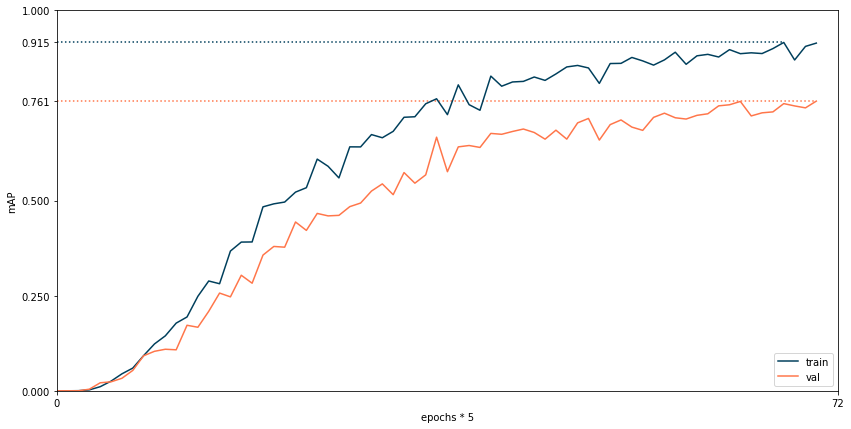

In [3]:
import matplotlib.pyplot as plt
train_max = [max(df["train"]),np.argmax(df["train"])]
val_max = [max(df["val"]),np.argmax(df["val"])]
x_ax = [0, len(df)+1]
y_ax = [0, .25, .5, val_max[0], train_max[0], 1]
plt.figure(0)
plt.plot(train_max[1], train_max[0])
plt.plot([0,train_max[1]], [train_max[0], train_max[0]], color = "#003f5c", linestyle=":")

plt.plot(val_max[1], val_max[0])
plt.plot([0,val_max[1]], [val_max[0], val_max[0]], color = "#ff764a", linestyle=":")

plt.plot(df["train"], label="train", color= "#003f5c")
plt.plot(df["val"], label="val", color= "#ff764a")
plt.ylim(.2,1)
plt.xlim(0, 50)

plt.gcf().set_size_inches(14,7)
plt.xlabel('epochs * 5')
plt.xticks(x_ax)
plt.ylabel('mAP')
plt.yticks(y_ax)
plt.legend()
plt.show()

In [3]:
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=C.IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=C.IMAGE_SIZE, min_width=C.IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255, ),
        ToTensorV2(),
    ],
)

In [4]:
model = YOLO(num_classes=C.NUM_CLASSES).to(C.DEVICE)
check = "lib/models/checkpoint_test2.pth.tar"
optimizer = optim.Adam(
        model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY
    )
load_checkpoint(
        check, model, optimizer, C.LEARNING_RATE
    )
#model.load_state_dict(torch.load("lib/models/checkpoint_test2.pth.tar")["state_dict"])

=> Loading checkpoint


In [27]:
#(x, model, anchors, device="cuda", iou_threshold, threshold)
pred_boxes = get_eval_boxes(image, model, C.ANCHORS, iou_threshold = C.NMS_IOU_THRESH, threshold=C.CONF_THRESHOLD)
pred_boxes

[[0,
  3.0,
  0.929430365562439,
  0.6880135536193848,
  0.20467597246170044,
  0.058393631130456924,
  0.056485630571842194]]

In [29]:
targets =  = pred_boxes[0]
test

[0,
 3.0,
 0.929430365562439,
 0.6880135536193848,
 0.20467597246170044,
 0.058393631130456924,
 0.056485630571842194]

0.20467597246170044


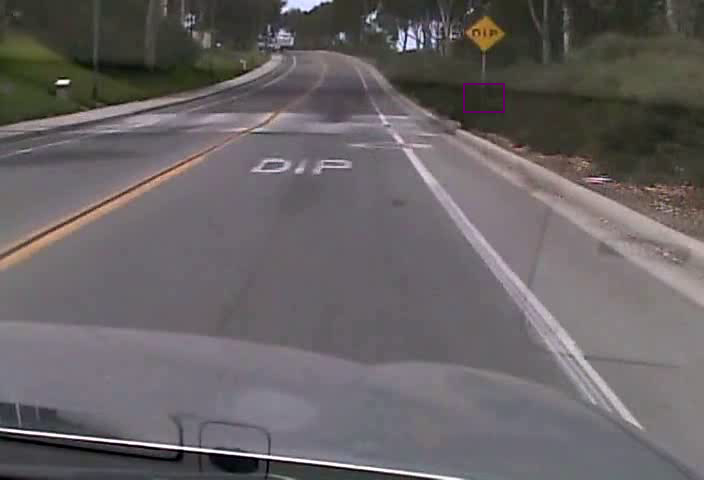

In [28]:
image = Image.open(image_path)
#image = image.resize((416, 416))
bboxes = pred_boxes
width, height = image.size
width, height
ids = pd.read_csv("lib/datasets/ids.csv")

for count, box in enumerate(bboxes):
    color = (100+count*int(155/4), 0, 100+count*int(155/4))
    name = ids[ids["ID"] == int(box[0])]["Name"].tolist()[0]
    x = box[3]
    y = box[4]
    w = box[5]
    h = box[6]
    left, right, top, bottom = [(x - w / 2) * width, (x + w / 2) * width, 
                                (y - h / 2) * height, (y + h / 2) * height]
    print(y)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    draw = ImageDraw.Draw(image)
    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=2, fill=color)
    font = ImageFont.truetype("arial.ttf", 30)
    #draw.text((int(left+5),int(top-30)), name, fill=color, font=font)
image

In [30]:
#464;16;506;51
image.size[1] * test[4], image.size

(98.24446678161621, (704, 480))

In [10]:
scaled_anchors = (
    torch.tensor(C.ANCHORS)
    * torch.tensor(C.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(C.DEVICE)
# scaled_anchors = (torch.tensor(anchors) / (
#         1 / torch.tensor(C.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
# )).to("cuda")
image = image.to("cuda")

with torch.no_grad():
    model.eval()
    tmp = torch.reshape(image,(1,image.size()[0],image.size()[1],image.size()[2]))
    out = model(tmp)
    bboxes = [[] for _ in range(image.shape[0])]
    for i in range(3):
        batch_size, A, S, _, _ = out[i].size()
        anchor = scaled_anchors[i]
        boxes_scale_i = cells_to_bboxes(
            out[i], anchor, S=S, is_preds=True
        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box
            
    for i in range(batch_size):
        nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=C.NMS_IOU_THRESH, threshold=C.CONF_THRESHOLD, box_format="midpoint",
        )

In [11]:
scaled_anchors

tensor([[[ 3.6400,  2.8600],
         [ 4.9400,  6.2400],
         [11.7000, 10.1400]],

        [[ 1.8200,  3.9000],
         [ 3.9000,  2.8600],
         [ 3.6400,  7.5400]],

        [[ 1.0400,  1.5600],
         [ 2.0800,  3.6400],
         [ 4.1600,  3.1200]]], device='cuda:0')

In [13]:
anchors = scaled_anchors[0].reshape(1, len(scaled_anchors[0]), 1, 1, 2)
anchors

tensor([[[[[ 3.6400,  2.8600]]],


         [[[ 4.9400,  6.2400]]],


         [[[11.7000, 10.1400]]]]], device='cuda:0')

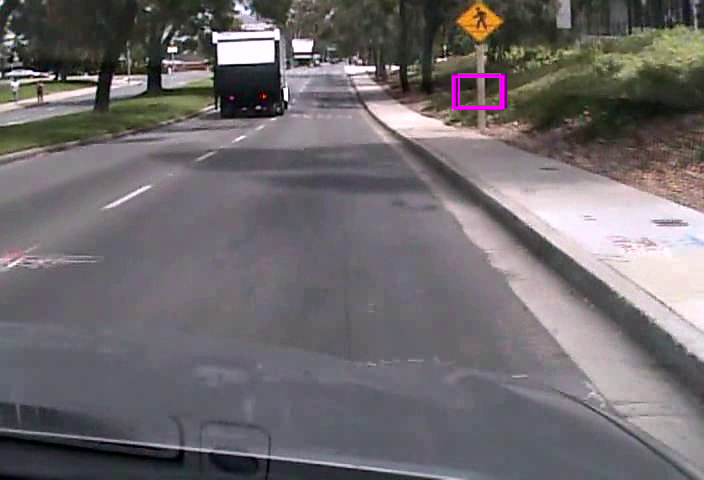

In [45]:
image = Image.open(image_path)
#image = image.resize((416, 416))
bboxes = nms_boxes
width, height = image.size
width, height
ids = pd.read_csv("lib/datasets/ids.csv")

for count, box in enumerate(bboxes):
    color = (100+count*int(155/4), 0, 100+count*int(155/4))
    name = ids[ids["ID"] == int(box[0])]["Name"].tolist()[0]
    x = box[2]
    y = box[3]
    w = box[4]
    h = box[5]
    left, right, top, bottom = [(x - w / 2) * width, (x + w / 2) * width, 
                                (y - h / 2) * height, (y + h / 2) * height]
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    draw = ImageDraw.Draw(image)
    draw.line([(left, top), (left, bottom), (right, bottom),(right, top), (left, top)], width=2, fill=color)
    font = ImageFont.truetype("arial.ttf", 30)
    #draw.text((int(left+5),int(top-30)), name, fill=color, font=font)
image

In [13]:
bboxes

[[12.0,
  0.9365957975387573,
  0.6800687909126282,
  0.19031743705272675,
  0.07512444257736206,
  0.06832115352153778]]

In [ ]:
[[0,
  12.0,
  0.9079296588897705,
  0.68320232629776,
  0.18852829933166504,
  0.07225465774536133,
  0.06570666283369064]]

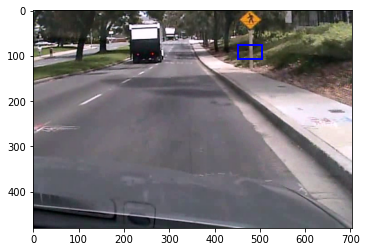

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#lab, conf, x, y, w, h
bboxes = nms_boxes
image = Image.open(image_path)
#cmap = plt.get_cmap("tab20b")
im = np.array(image)
width, height = image.size
fig, ax = plt.subplots(1)
# Display the image
ax.imshow(im)
for box in bboxes:
    box = box[2:]
    upper_left_x = box[0] - box[2] / 2
    upper_left_y = box[1] - box[3] / 2
    rect = patches.Rectangle(
        (upper_left_x * width, upper_left_y * height),
        box[2] * width,
        box[3] * height,
        linewidth=2,
        edgecolor="blue",
        facecolor="none",
    )
    ax.add_patch(rect)
plt.show()
    
# real_x, real_y, real_w, real_h = [bboxes[0][2] * image.size[0], bboxes[0][3] * image.size[1], 
#                                   bboxes[0][4] * image.size[0], bboxes[0][5] * image.size[1]]
# draw = ImageDraw.Draw(image)
# draw.rectangle(((real_x - real_w / 2, real_y- real_h / 2), (real_x + real_w / 2, real_y + real_h / 2)))
# image

In [14]:
box = bboxes[0]
box[2:]

[[7.0,
  0.8299887776374817,
  0.27858415246009827,
  0.6355882287025452,
  0.04907380789518356,
  0.04878328740596771],
 [28.0,
  0.7394236922264099,
  0.9782129526138306,
  0.5365965962409973,
  0.037033919245004654,
  0.05833607167005539]]

In [24]:
tmp = torch.reshape(image,(1,image.size()[0],image.size()[1],image.size()[2]))
out = model(tmp)
out[0].size()

torch.Size([1, 3, 13, 13, 52])

In [4]:
IMAGE_SIZE = 416
val_dataset = LISADataset("val.csv", "val_list.npy", S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
                           transform = C.test_transforms, anchors = C.ANCHORS)
val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=C.BATCH_SIZE,
        num_workers=C.NUM_WORKERS,
        pin_memory=C.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
x, y = next(iter(val_loader))

NameError: name 'LISADataset' is not defined